# AA Project - Neural Networks
Alexandre Gonçalves, aluno 100121


# Data Preprocessing

**1. Importing the dataset**

In [1]:
import pandas as pd

df = pd.read_csv('diabetes_012_health_indicators_BRFSS2015.csv')
df.describe()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,...,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.296921,0.429001,0.424121,0.962670,28.382364,0.443169,0.040571,0.094186,0.756544,0.634256,...,0.951053,0.084177,2.511392,3.184772,4.242081,0.168224,0.440342,8.032119,5.050434,6.053875
std,0.698160,0.494934,0.494210,0.189571,6.608694,0.496761,0.197294,0.292087,0.429169,0.481639,...,0.215759,0.277654,1.068477,7.412847,8.717951,0.374066,0.496429,3.054220,0.985774,2.071148
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,0.000000,0.000000,1.000000,27.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,2.000000,3.000000,0.000000,1.000000,10.000000,6.000000,8.000000
max,2.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


**2. Checking if there are any missing values**


In [2]:
df.isnull().values.any()

False

**3. Assessing if the Data is balanced**

In [3]:
df = df.sort_values(by=['Diabetes_012'])
value_counts = df.value_counts('Diabetes_012')
print(value_counts)

Diabetes_012
0    213703
2     35346
1      4631
Name: count, dtype: int64


As we can see, the class 1 is the least prevalent in our data. To balance the dataset we will undersample the obeservations with other classes as to have data with the same frequency of each class.

**4. Balancing the dataset**

In order to do this we will establish a desired number of observations and use undersampling (simply remove entries) from the classes that currently have a higher number and oversampling (in this case, using some of the entries more than once) on the classes that are smaller.

In [4]:
import pandas as pd
from balance_dataset import *

df = balance_classes(df,'Diabetes_012',10000)
print(df.value_counts('Diabetes_012'))

Diabetes_012
0    10000
1    10000
2    10000
Name: count, dtype: int64


As we can see, the dataset is now balanced.

**5. Scaling the data**

In [59]:
from sklearn.preprocessing import MinMaxScaler

seed = 42
x = df.drop(columns = ['Diabetes_012']).astype('float64')

transformer_x = MinMaxScaler().fit(x)                                                      
x_scaled = pd.DataFrame(transformer_x.transform(x), columns = x.columns)

#Thankfully, because our target variable is categorical, it doesnt have to be scaled:
y_scaled = df['Diabetes_012'].astype('float64') 

**6. Splitting the data into scaled train/test/val sets:**

In [60]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

x_train, x_val, y_train, y_val = train_test_split(x_scaled.values, y_scaled.values, train_size = 0.7, random_state = seed)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, train_size = 0.66, random_state = seed)

**7. One-hot encoding**

For multiclass classification, it's standard practice to use one-hot encoding. This process converts categorical integer labels into a vector. For example, the class 0 becomes [1, 0, 0]

In [61]:
import tensorflow as tf

y_val = tf.keras.utils.to_categorical(y_val, num_classes=3)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)

# Neural Networks

In order to figure out the best architecture for our model, we are going to perform some hyperparameter tuning using scikit-learn's 'GridSearchCV'.
We will first establish the best combination of number of neurons and hidden layers and later on we will optimize some other key parameters of our network.

**1. Aplying grid search to the number of neurons/number of hidden layers**

In [10]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow import keras
from model_constructors import *

arquitectures = [[5],[25],[100],[25,5]]

model = KerasClassifier(build_fn=studymodel, activationf='relu', verbose=1,arquitetura = [20],lrate=1e-4,drop=0.2, epochs=500,batch_size = 64,x_train=x_train)
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50)

params = {'arquitetura':arquitectures}
gridsearch = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=5, verbose=2,refit=True)
gridsearch_result = gridsearch.fit(x_train, y_train, validation_data=(x_val, y_val))

print("The best model attained is: "+ str(gridsearch_result.best_params_)+", with a score of: "+str(round(gridsearch_result.best_score_*100))+"%.")

arquitetura_final = gridsearch_result.best_params_["arquitetura"]

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\agonc\AppData\Roaming\Python\Python39\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/500
329/329 [==============================] - 2s 3ms/step - loss: 1.0989 - f1_score: 0.3701 - precision: 0.4566 - auc: 0.5682 - sensitivity: 0.0509 - accuracy: 0.3836 - val_loss: 1.0501 - val_f1_score: 0.4653 - val_precision: 0.6036 - val_auc: 0.6465 - val_sensitivity: 0.0184 - val_accuracy: 0.4633
Epoch 2/500
329/329 [==============================] - 1s 2ms/step - loss: 1.0415 - f1_score: 0.4520 - precision: 0.5710 - auc: 0.6391 - sensitivity: 0.0993 - accuracy: 0.4521 - val_loss: 1.0158 - val_f1_score: 0.4838 - val_precision: 0.6632 - val_auc: 0.6694 - val_sensitivity: 0.1253 - val_accuracy: 0.4850
Epoch 3/500
329/329 [==============================] - 1s 2ms/step - loss: 1.0123 - f1_score: 0.4782 - precision: 0.6001 - auc: 0.6657 - sensitivity: 0.1777 - accuracy: 0.4814 - val_loss: 0.9999 - val_f1_score: 0.4818 - val_precision: 0.6215 - val_auc: 0.6771 - val_sensitivity: 0.1896 - val_accuracy: 0.4875
Epoch 4/500
329/329 [==============================] - 1s 2ms/step - loss

**2. Aplying grid search to the activation function**

In [11]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

functions = ['relu', 'sigmoid', 'tanh']

model = KerasClassifier(build_fn=studymodel, activationf='relu', verbose=1,arquitetura = arquitetura_final,lrate=1e-4,drop=0.2, epochs=500,batch_size = 64,x_train=x_train)
params = {'activationf': functions}
gridsearch = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=5, verbose=2,refit=True)
gridsearch_result = gridsearch.fit(x_train, y_train, validation_data=(x_val, y_val))

print("The best model attained is: "+ str(gridsearch_result.best_params_)+", with a score of: "+str(round(gridsearch_result.best_score_*100))+"%.")

activationf_final = gridsearch_result.best_params_['activationf']

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Epoch 1/500


C:\Users\agonc\AppData\Roaming\Python\Python39\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


329/329 [==============================] - 2s 3ms/step - loss: 1.0773 - f1_score: 0.4119 - precision: 0.4762 - auc_1: 0.5897 - sensitivity: 0.0331 - accuracy: 0.4104 - val_loss: 1.0371 - val_f1_score: 0.4706 - val_precision: 0.5421 - val_auc_1: 0.6635 - val_sensitivity: 0.0192 - val_accuracy: 0.4781
Epoch 2/500
329/329 [==============================] - 1s 2ms/step - loss: 1.0318 - f1_score: 0.4600 - precision: 0.6142 - auc_1: 0.6474 - sensitivity: 0.1155 - accuracy: 0.4652 - val_loss: 1.0062 - val_f1_score: 0.4835 - val_precision: 0.6830 - val_auc_1: 0.6799 - val_sensitivity: 0.1342 - val_accuracy: 0.4894
Epoch 3/500
329/329 [==============================] - 1s 2ms/step - loss: 1.0069 - f1_score: 0.4758 - precision: 0.6136 - auc_1: 0.6676 - sensitivity: 0.1915 - accuracy: 0.4829 - val_loss: 0.9925 - val_f1_score: 0.4768 - val_precision: 0.6497 - val_auc_1: 0.6844 - val_sensitivity: 0.1990 - val_accuracy: 0.4919
Epoch 4/500
329/329 [==============================] - 1s 2ms/step - loss

**3. Aplying grid search to the learning rate**

In [12]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

lrates = [7e-3,1e-3,1e-4]

model = KerasClassifier(build_fn=studymodel, activationf=activationf_final, verbose=1,arquitetura = arquitetura_final,lrate=1e-4,drop=0.2, epochs=500,batch_size = 64,x_train=x_train)
params = {'lrate': lrates}
gridsearch = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=5, verbose=2,refit=True)
gridsearch_result = gridsearch.fit(x_train, y_train, validation_data=(x_val, y_val))

print("The best model attained is: "+ str(gridsearch_result.best_params_)+", with a score of: "+str(round(gridsearch_result.best_score_*100))+"%.")

lrate_final = gridsearch_result.best_params_['lrate']

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Epoch 1/500


C:\Users\agonc\AppData\Roaming\Python\Python39\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


329/329 [==============================] - 2s 3ms/step - loss: 0.9994 - f1_score: 0.4810 - precision: 0.6074 - auc_2: 0.6738 - sensitivity: 0.2092 - accuracy: 0.4898 - val_loss: 0.9747 - val_f1_score: 0.4977 - val_precision: 0.6483 - val_auc_2: 0.6952 - val_sensitivity: 0.2374 - val_accuracy: 0.5005
Epoch 2/500
329/329 [==============================] - 1s 2ms/step - loss: 0.9702 - f1_score: 0.5011 - precision: 0.6274 - auc_2: 0.6963 - sensitivity: 0.2600 - accuracy: 0.5098 - val_loss: 0.9660 - val_f1_score: 0.4992 - val_precision: 0.6388 - val_auc_2: 0.7013 - val_sensitivity: 0.2673 - val_accuracy: 0.5099
Epoch 3/500
329/329 [==============================] - 1s 2ms/step - loss: 0.9609 - f1_score: 0.5042 - precision: 0.6307 - auc_2: 0.7041 - sensitivity: 0.2745 - accuracy: 0.5154 - val_loss: 0.9596 - val_f1_score: 0.5039 - val_precision: 0.6359 - val_auc_2: 0.7058 - val_sensitivity: 0.2713 - val_accuracy: 0.5170
Epoch 4/500
329/329 [==============================] - 1s 2ms/step - loss

**4. Aplying grid search to the batch size**

In [13]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

batch_sizes = [16,32,64]

model = KerasClassifier(build_fn=studymodel, activationf=activationf_final, verbose=1,arquitetura = arquitetura_final,lrate=lrate_final,drop=0.2, epochs=500,batch_size = 64,x_train=x_train)
params = {'batch_size':batch_sizes}
gridsearch = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=5, verbose=2,refit=True)
gridsearch_result = gridsearch.fit(x_train, y_train, validation_data=(x_val, y_val))

print("The best model attained is: "+ str(gridsearch_result.best_params_)+", with a score of: "+str(round(gridsearch_result.best_score_*100))+"%.")

batch_final = gridsearch_result.best_params_['batch_size']

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Epoch 1/500


C:\Users\agonc\AppData\Roaming\Python\Python39\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


329/329 [==============================] - 2s 3ms/step - loss: 1.0087 - f1_score: 0.4714 - precision: 0.5861 - auc_3: 0.6646 - sensitivity: 0.2052 - accuracy: 0.4773 - val_loss: 0.9767 - val_f1_score: 0.4965 - val_precision: 0.6460 - val_auc_3: 0.6947 - val_sensitivity: 0.2425 - val_accuracy: 0.5044
Epoch 2/500
329/329 [==============================] - 1s 2ms/step - loss: 0.9745 - f1_score: 0.4973 - precision: 0.6180 - auc_3: 0.6934 - sensitivity: 0.2637 - accuracy: 0.5056 - val_loss: 0.9654 - val_f1_score: 0.4925 - val_precision: 0.6384 - val_auc_3: 0.7018 - val_sensitivity: 0.2683 - val_accuracy: 0.5118
Epoch 3/500
329/329 [==============================] - 1s 2ms/step - loss: 0.9636 - f1_score: 0.5059 - precision: 0.6320 - auc_3: 0.7020 - sensitivity: 0.2707 - accuracy: 0.5146 - val_loss: 0.9614 - val_f1_score: 0.5123 - val_precision: 0.6546 - val_auc_3: 0.7037 - val_sensitivity: 0.2524 - val_accuracy: 0.5210
Epoch 4/500
329/329 [==============================] - 1s 2ms/step - loss

**5. Plotting the training and the validation loss**

Epoch 1/500
329/329 [==============================] - 2s 3ms/step - loss: 1.0036 - f1_score: 0.4764 - precision: 0.5945 - auc_4: 0.6682 - sensitivity: 0.2088 - accuracy: 0.4843 - val_loss: 0.9719 - val_f1_score: 0.4925 - val_precision: 0.6412 - val_auc_4: 0.6965 - val_sensitivity: 0.2570 - val_accuracy: 0.5089
Epoch 2/500
329/329 [==============================] - 1s 2ms/step - loss: 0.9701 - f1_score: 0.4990 - precision: 0.6262 - auc_4: 0.6963 - sensitivity: 0.2670 - accuracy: 0.5076 - val_loss: 0.9673 - val_f1_score: 0.4952 - val_precision: 0.6440 - val_auc_4: 0.7008 - val_sensitivity: 0.2449 - val_accuracy: 0.5052
Epoch 3/500
329/329 [==============================] - 1s 2ms/step - loss: 0.9595 - f1_score: 0.5054 - precision: 0.6361 - auc_4: 0.7037 - sensitivity: 0.2726 - accuracy: 0.5152 - val_loss: 0.9598 - val_f1_score: 0.5161 - val_precision: 0.6473 - val_auc_4: 0.7047 - val_sensitivity: 0.2594 - val_accuracy: 0.5197
Epoch 4/500
329/329 [==============================] - 1s 2ms

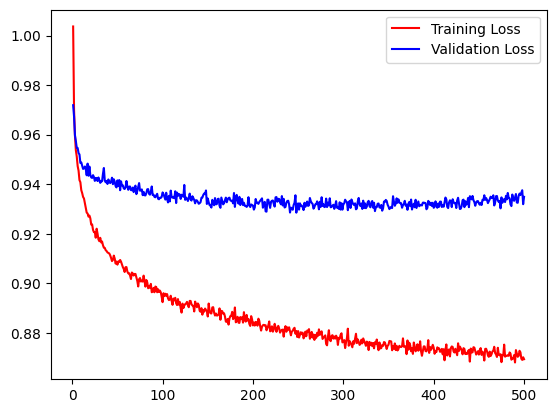

In [14]:
from tensorflow import keras

finalmodel = studymodel(activationf=activationf_final, arquitetura = arquitetura_final, lrate = lrate_final, drop=0.2,x_train=x_train)

history = finalmodel.fit(x_train, y_train, epochs=500, batch_size=batch_final, verbose=1, validation_data=(x_val, y_val))

losses = pd.DataFrame(data = {
    'epoch': range(1,501),
    'loss': history.history['loss'],
    'val_loss': history.history['val_loss'],
    'f1_score': history.history['f1_score'],
    'val_f1_score': history.history['val_f1_score']
})
losses = losses.groupby(by = 'epoch').mean().reset_index()

plt.plot(losses.epoch, losses.loss, 'r-', label = 'Training Loss')
plt.plot(losses.epoch, losses.val_loss, 'b-', label = 'Validation Loss')
plt.legend()
plt.show()

**6. Plotting the training and the validation F1-score**

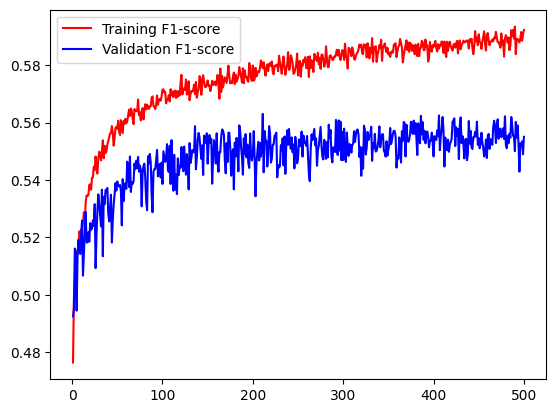

In [15]:
plt.plot(losses['epoch'], losses['f1_score'], 'r-', label = 'Training F1-score')
plt.plot(losses['epoch'], losses['val_f1_score'], 'b-', label = 'Validation F1-score')
plt.legend()
plt.show()

**7. Plotting the confusion matrixes**

In [17]:
from sklearn.metrics import confusion_matrix, accuracy_score

## Training
y_pred = finalmodel.predict(x_train)
print('Training Confusion Matrix')
print(confusion_matrix(y_train.argmax(axis=1), y_pred.argmax(axis=1).round()))
print(accuracy_score(y_train.argmax(axis=1), y_pred.argmax(axis=1).round()))
print('')

## Validation
y_pred = finalmodel.predict(x_val)
print('Validation Confusion Matrix')
print(confusion_matrix(y_val.argmax(axis=1), y_pred.argmax(axis=1).round()))
print(accuracy_score(y_val.argmax(axis=1), y_pred.argmax(axis=1).round()))
print('')

## Test
y_pred = finalmodel.predict(x_test)
print('Test Confusion Matrix')
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1).round()))
print(accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1).round()))
print('')

657/657 [==============================] - 1s 961us/step
Training Confusion Matrix
[[4584 1071 1337]
 [1355 3565 2086]
 [ 915 1335 4752]]
0.6143333333333333

186/186 [==============================] - 0s 931us/step
Validation Confusion Matrix
[[1214  374  405]
 [ 429  849  667]
 [ 297  453 1252]]
0.5580808080808081

96/96 [==============================] - 0s 912us/step
Test Confusion Matrix
[[632 164 219]
 [228 467 354]
 [137 298 561]]
0.5424836601307189



# Improvements
**1. Feature Selection**

In [49]:
finalmodel = L1model(activationf='relu', arquitetura = [100], lrate = 0.001, drop=0.2)
history = finalmodel.fit(x_train, y_train, epochs=500, batch_size=64, verbose=1, validation_data=(x_val, y_val),x_train=x_train)

Epoch 1/500
329/329 [==============================] - 2s 3ms/step - loss: 1.1812 - f1_score: 0.4886 - precision: 0.5880 - auc_6: 0.6828 - accuracy: 0.4959 - sensitivity: 0.2810 - val_loss: 1.1044 - val_f1_score: 0.5019 - val_precision: 0.6219 - val_auc_6: 0.7053 - val_accuracy: 0.5136 - val_sensitivity: 0.2885
Epoch 2/500
329/329 [==============================] - 1s 2ms/step - loss: 1.0729 - f1_score: 0.5102 - precision: 0.6266 - auc_6: 0.7079 - accuracy: 0.5186 - sensitivity: 0.2890 - val_loss: 1.0429 - val_f1_score: 0.5118 - val_precision: 0.6607 - val_auc_6: 0.7079 - val_accuracy: 0.5135 - val_sensitivity: 0.2556
Epoch 3/500
329/329 [==============================] - 1s 2ms/step - loss: 1.0222 - f1_score: 0.5199 - precision: 0.6460 - auc_6: 0.7140 - accuracy: 0.5270 - sensitivity: 0.2748 - val_loss: 1.0070 - val_f1_score: 0.4992 - val_precision: 0.6423 - val_auc_6: 0.7090 - val_accuracy: 0.5140 - val_sensitivity: 0.2813
Epoch 4/500
329/329 [==============================] - 1s 2ms

**2. Improving model complexity**

In [64]:
finalmodel = studymodel(activationf='relu', arquitetura = [150,100,50,25], lrate = 0.001, drop=0.2)
history = finalmodel.fit(x_train, y_train, epochs=1000, batch_size=64, verbose=1, validation_data=(x_val, y_val),x_train=x_train)

Epoch 1/1000
329/329 [==============================] - 2s 4ms/step - loss: 0.9788 - f1_score: 0.4905 - precision: 0.6233 - auc_12: 0.6878 - sensitivity: 0.2417 - accuracy: 0.5009 - val_loss: 0.9481 - val_f1_score: 0.5098 - val_precision: 0.6757 - val_auc_12: 0.7133 - val_sensitivity: 0.2439 - val_accuracy: 0.5219
Epoch 2/1000
329/329 [==============================] - 1s 3ms/step - loss: 0.9499 - f1_score: 0.5157 - precision: 0.6506 - auc_12: 0.7118 - sensitivity: 0.2665 - accuracy: 0.5241 - val_loss: 0.9472 - val_f1_score: 0.5147 - val_precision: 0.6601 - val_auc_12: 0.7157 - val_sensitivity: 0.2569 - val_accuracy: 0.5269
Epoch 3/1000
329/329 [==============================] - 1s 3ms/step - loss: 0.9471 - f1_score: 0.5234 - precision: 0.6541 - auc_12: 0.7159 - sensitivity: 0.2692 - accuracy: 0.5301 - val_loss: 0.9454 - val_f1_score: 0.5060 - val_precision: 0.6570 - val_auc_12: 0.7175 - val_sensitivity: 0.2653 - val_accuracy: 0.5276
Epoch 4/1000
329/329 [==============================

Plotting the ROC curve of the final model

96/96 [==============================] - 0s 1ms/step


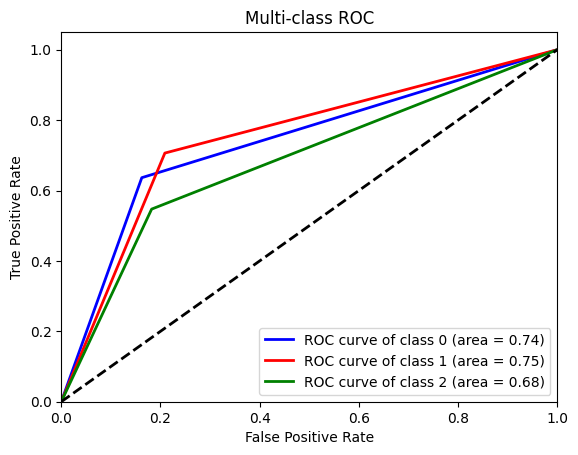

In [82]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize


y_pred = finalmodel.predict(x_test).argmax(axis=1)

newy_pred = label_binarize(y_pred, classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], newy_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plotting the ROC curves
colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()
